# Timeseries models - ShoreShop

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from functions.data_load import load_modelling_data, tabularise_raw_data

from functions.inference.utils import (
    calc_skill,
    print_skill
)

## Load the data

Load the data using `load_modelling_data()` that returns a dictionary containing the following pandas DataFrames mirroring `1.data_explore.ipynb` (with indices as datetime objects where possible):

- `df_tran`: Transect data.
- `df_gt`: Groundtruth shoreline positions.
- `df_targ_short`: Short-term target shoreline positions.
- `df_targ_medium`: Medium-term target shoreline positions.
- `df_obs`: Observed shoreline positions.
- `dfs_wave`: Wave data for different parameters ('Hs', 'Tp', 'Dir').
- `df_SLR_obs`: Observed sea level rise data.
- `df_SLR_proj`: Projected sea level rise data.

Provided information:
A sequence of shore-normal transects were defined from North to South.\
The distance between transects is 100 m alongshore\
The coordinates of transects were intentionally shifted.

Shoreline positions were retrieved from Landsat 5, 7, 8 and 9 satellite images with [CoastSat toolbox](https://github.com/kvos/CoastSat/tree/master).\
All the shorelines have been corrected to reflect the instaneous position at Mean Sea Level\
Only shorelines from 1987 to 2018 are avaiable for model training/calibration in this site.\
Along each transect, shoreline positions were provided as the distance to the **landward** end of the transect.

Offshore wave data is from [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) wave spectra data.\
SWAN model was used to transfer offshore wave into nearshore with [Binwave](https://www.sciencedirect.com/science/article/pii/S1463500324000337) approach developed by Dr Laura Cagigal.\
Along each transect, the wave data was extracted at 10m contour 

In [3]:
basedir = '.' # where are you in relation to the root directory
raw_data = load_modelling_data(basedir=basedir)

df_tran: Loaded 9 transects...
df_gt: Loaded (3, 9) (dates,transects) groundtruth shoreline positions...1999-06-20 to 2018-08-17
df_targ_short: Loaded (118, 9) (dates,transects) short-term target shoreline positions...2019-01-15 to 2023-12-28
df_targ_medium: Loaded (114, 9) (dates,transects) medium-term target shoreline positions...1951-05-01 to 1998-10-27
df_obs: Loaded (347, 9) (dates,transects) observed shoreline positions...1999-02-17 to 2018-12-30
dfs_wave["Hs"]: Loaded (30678, 9) (dates,transects) Hs wave data...
dfs_wave["Tp"]: Loaded (30678, 9) (dates,transects) Tp wave data...
dfs_wave["Dir"]: Loaded (30678, 9) (dates,transects) Dir wave data...
Wave data spans: 1940-01-02 to 2023-12-29 at 1 day(s) interval
df_SLR_obs: Loaded (69, 1) (years, ['Sealevel (m)']) observed sea level rise data...1950 to 2018
df_SLR_proj: Loaded (81, 2) (years, ['RCP45', 'RCP85']) projected sea level rise data...2019 to 2099


## Optional preprocessing
Here is provided a template for optional preprocessing steps that can be used to tabularise the data for modelling. Adopted the frequency of the wave data, but this can of course be adjusted.

In [4]:
# Optional pre-processing
tabular_data = tabularise_raw_data(raw_data)

<Axes: xlabel='date', ylabel='shoreline'>

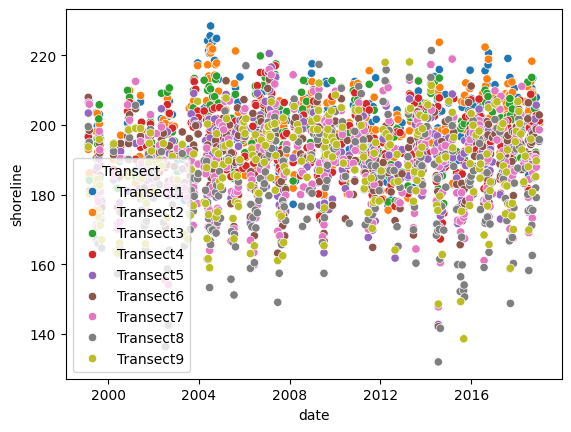

In [5]:
sns.scatterplot(tabular_data['df_obs'], hue='Transect', x='date', y='shoreline')

### Quick visualisation
Some quick visualisation of the data to show the format

We have daily data with intermittent shoreline position at 9 transects.

In [6]:
print(tabular_data.keys())
print(tabular_data['df_obs']['Transect'].unique())
tabular_data['df_obs']

dict_keys(['df_obs', 'df_targ_short', 'df_targ_medium'])
['Transect1' 'Transect2' 'Transect3' 'Transect4' 'Transect5' 'Transect6'
 'Transect7' 'Transect8' 'Transect9']


,date,Transect,shoreline,Hs,Tp,Dir
0,1999-02-17,Transect1,197.025794,1.278391,10.180599,87.879170
1,1999-02-18,Transect1,NaN,1.613118,10.515673,109.377224
2,1999-02-19,Transect1,NaN,1.384905,10.275089,127.935891
3,1999-02-20,Transect1,NaN,0.965775,9.764103,110.974377
4,1999-02-21,Transect1,NaN,1.222583,9.606054,106.006189
...,...,...,...,...,...,...
65308,2018-12-26,Transect9,NaN,1.200796,10.247938,99.339025
65309,2018-12-27,Transect9,NaN,1.208491,6.375795,85.126659
65310,2018-12-28,Transect9,NaN,1.313490,7.214175,71.430210
65311,2018-12-29,Transect9,NaN,1.338269,7.584354,73.688101


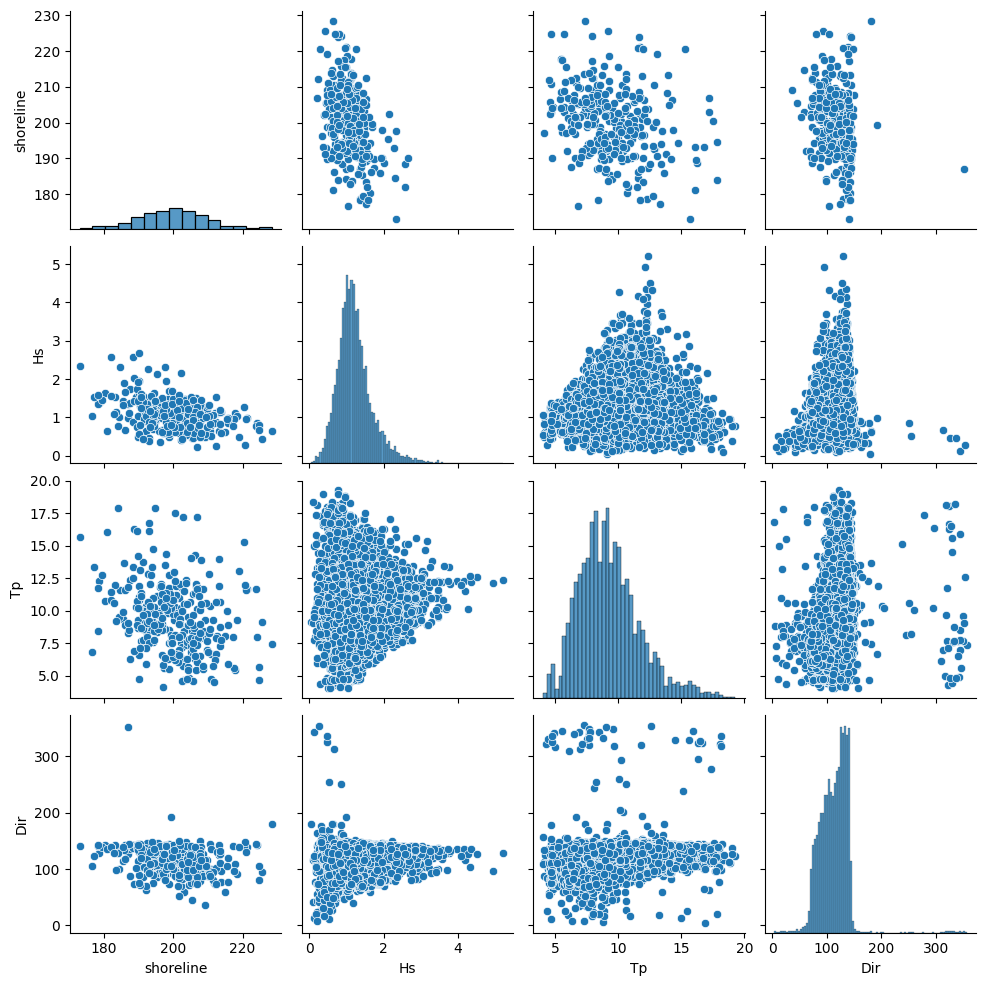

In [7]:
# pairplot the data
trans_id = 'Transect1'
sns.pairplot(
    tabular_data['df_obs'].query('Transect == @trans_id').drop(columns=['Transect','date'])
)
plt.show()

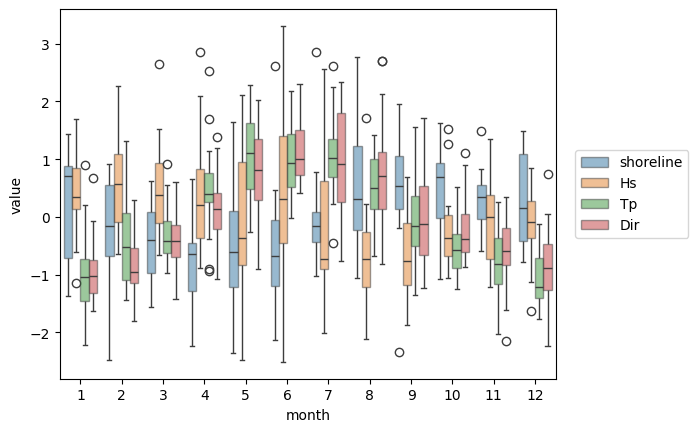

In [8]:
# plot the seasonal averages
trans_id = 'Transect1'
plot_data = tabular_data['df_obs'].query('Transect == @trans_id').drop(columns=['Transect']).set_index('date').resample('1ME').mean()
plot_data = plot_data.assign(month=plot_data.index.month)
# demean and stanardise the variables
for _ in [_ for _ in plot_data.columns if not _ in ['month']]:
    plot_data[_] = (plot_data[_] - plot_data[_].mean())/plot_data[_].std()
sns.boxplot(data=plot_data.melt(id_vars='month'),x='month',y='value',hue='variable',boxprops=dict(alpha=.5))
plt.legend(loc=6,bbox_to_anchor=(1.025,0.5))
plt.show()

### Prepare the data
Initially I will resample to monthly to avoid so many NaNs and other unpleasantries. Then we will cheekily gap fill the data, this will be a big exercise in missing data and the choice around how this is handled needs to be considered carefully.

In [9]:
# calculate how many non NaN values at each transect
print(tabular_data['df_obs'].groupby('Transect').count())

           date  shoreline    Hs    Tp   Dir
Transect                                    
Transect1  7257        300  7204  7257  7257
Transect2  7257        306  7204  7257  7257
Transect3  7257        316  7202  7257  7257
Transect4  7257        318  7200  7257  7257
Transect5  7257        312  7197  7257  7257
Transect6  7257        302  7198  7257  7257
Transect7  7257        306  7198  7257  7257
Transect8  7257        303  7198  7257  7257
Transect9  7257        253  7198  7257  7257


In [10]:
# split per Transect then average to monthly values with mean and peak for Hs and Tp then recombine into a reasonable dataframe
resampled_data = tabular_data['df_obs'].copy()
resampled_data = pd.concat(
    [
        resampled_data.query('Transect == @trans_id').drop(columns=['Transect']).set_index('date').resample('MS').agg({'Hs':['mean','max'],'Tp':['mean','max'],'Dir':['mean'],'shoreline':['mean']}).reset_index().assign(Transect=trans_id) for trans_id in resampled_data['Transect'].unique()
    ], axis=0
)
# combine the column names to make one level
resampled_data.columns = [
    '_'.join(col).strip() if '' != col[1] else col[0] for col in resampled_data.columns.values]
resampled_data = resampled_data.rename(columns={'shoreline_mean':'shoreline'})
# now add month predictor
resampled_data = resampled_data.assign(month=resampled_data['date'].dt.month-1)
resampled_data = resampled_data.reset_index(drop=True)
# get the shoreline position at t-1 but only for the same transect
resampled_data = resampled_data.assign(shoreline_tminus1=resampled_data.groupby('Transect')['shoreline'].shift(1))
# Keep only Transect6
resampled_data = resampled_data.query('Transect == "Transect7"').reset_index(drop=True)
resampled_data

,date,Hs_mean,Hs_max,Tp_mean,Tp_max,Dir_mean,shoreline,Transect,month,shoreline_tminus1
0,1999-02-01,1.663467,2.763754,10.339419,11.484928,110.122764,206.323159,Transect7,1,NaN
1,1999-03-01,1.274813,1.821781,8.833105,16.594411,111.032964,205.950591,Transect7,2,206.323159
2,1999-04-01,1.776314,3.864274,10.546417,16.270549,122.033493,NaN,Transect7,3,205.950591
3,1999-05-01,1.172672,2.826905,10.888008,18.991852,107.854207,NaN,Transect7,4,NaN
4,1999-06-01,1.232604,2.114144,9.403058,12.280283,124.855083,171.384529,Transect7,5,NaN
...,...,...,...,...,...,...,...,...,...,...
234,2018-08-01,1.014836,2.536119,10.673076,15.220283,115.490614,190.936752,Transect7,7,177.595634
235,2018-09-01,1.112081,1.700238,9.195693,15.876721,113.828244,182.376030,Transect7,8,190.936752
236,2018-10-01,1.436333,2.306837,9.064529,15.591436,107.192904,190.711102,Transect7,9,182.376030
237,2018-11-01,1.150216,2.587180,8.715029,18.927663,113.744622,189.180346,Transect7,10,190.711102


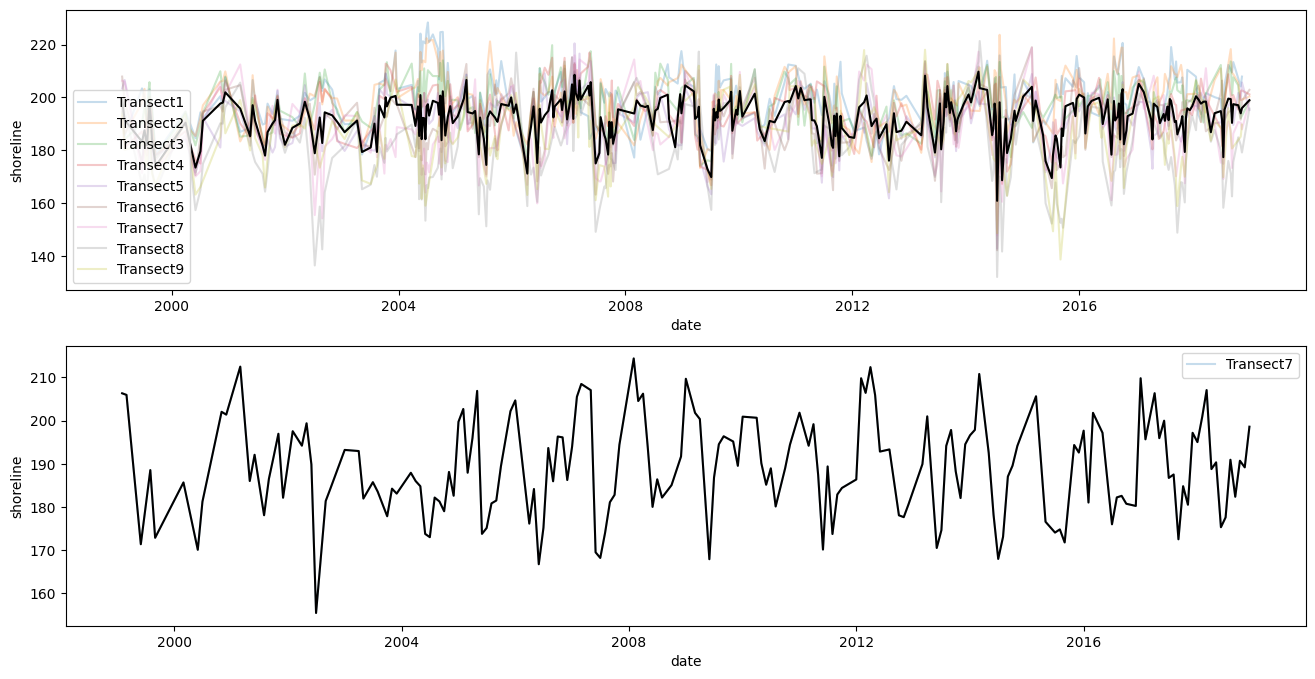

In [11]:
# vis of transect data
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.lineplot(data=tabular_data['df_obs'],y='shoreline',x='date', hue='Transect', ax=ax1, alpha=0.25)
sns.lineplot(data=tabular_data['df_obs'],y='shoreline',x='date', ax=ax1, color = 'k', errorbar=None)

sns.lineplot(data=resampled_data,y='shoreline', x='date', hue='Transect', ax=ax2, alpha=0.25)
sns.lineplot(data=resampled_data,y='shoreline', x='date', ax=ax2, color = 'k', errorbar=None)
sns.lineplot(data=resampled_data.query('Transect == "Transect1"'),y='shoreline', x='date', color = 'C0', ax=ax2, alpha=0.75)
sns.lineplot(data=resampled_data.query('Transect == "Transect9"'),y='shoreline', x='date', color = 'C3', ax=ax2, alpha=0.75)
plt.show()



In [12]:
# Split into training 1999-2016 and testing 2017-2019
train_data = resampled_data.query('date < "2017-01-01"').reset_index(drop=True)
test_data = resampled_data.query('date >= "2017-01-01"').reset_index(drop=True)

# Create the modelling copies

In [13]:
train_data_clean = train_data.copy()
test_data_clean = test_data.copy()
train_data_out = train_data_clean.copy()
test_data_out = test_data_clean.copy()

display(train_data_clean)
display(test_data_clean)

,date,Hs_mean,Hs_max,Tp_mean,Tp_max,Dir_mean,shoreline,Transect,month,shoreline_tminus1
0,1999-02-01,1.663467,2.763754,10.339419,11.484928,110.122764,206.323159,Transect7,1,NaN
1,1999-03-01,1.274813,1.821781,8.833105,16.594411,111.032964,205.950591,Transect7,2,206.323159
2,1999-04-01,1.776314,3.864274,10.546417,16.270549,122.033493,NaN,Transect7,3,205.950591
3,1999-05-01,1.172672,2.826905,10.888008,18.991852,107.854207,NaN,Transect7,4,NaN
4,1999-06-01,1.232604,2.114144,9.403058,12.280283,124.855083,171.384529,Transect7,5,NaN
...,...,...,...,...,...,...,...,...,...,...
210,2016-08-01,1.048323,2.561521,8.944837,14.828635,115.920642,182.218122,Transect7,7,176.002107
211,2016-09-01,1.000898,1.975639,9.491778,17.878551,112.230048,182.580889,Transect7,8,182.218122
212,2016-10-01,1.059080,2.686100,9.362160,17.672199,115.114669,180.752003,Transect7,9,182.580889
213,2016-11-01,1.036432,1.662292,9.593338,15.307184,115.827554,NaN,Transect7,10,180.752003


,date,Hs_mean,Hs_max,Tp_mean,Tp_max,Dir_mean,shoreline,Transect,month,shoreline_tminus1
0,2017-01-01,1.219797,1.721972,8.497867,13.497242,109.656127,209.806297,Transect7,0,180.245128
1,2017-02-01,1.192073,2.058664,8.252566,15.384756,105.201304,195.672438,Transect7,1,209.806297
2,2017-03-01,1.714010,2.877094,8.952049,11.733728,107.777368,NaN,Transect7,2,195.672438
3,2017-04-01,1.346548,2.321532,10.463462,13.029242,111.573672,206.343625,Transect7,3,NaN
4,2017-05-01,1.077001,1.896467,10.598658,17.413851,115.840609,195.934001,Transect7,4,206.343625
5,2017-06-01,1.268986,1.929087,10.568614,16.907781,119.850720,199.981859,Transect7,5,195.934001
6,2017-07-01,0.947379,2.657683,10.245065,16.968668,133.701399,186.736459,Transect7,6,199.981859
7,2017-08-01,1.184385,3.025489,10.596378,22.329153,134.533245,187.522988,Transect7,7,186.736459
8,2017-09-01,0.995066,1.989323,10.718945,15.913989,119.899518,172.529686,Transect7,8,187.522988
9,2017-10-01,1.154948,1.772475,8.171369,12.131750,110.758387,184.821357,Transect7,9,172.529686


## Modelling attempt
Here you can construct your model and make some predictions.

In [14]:
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

# NumPyro for proabilistic programming
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

# NumPyro for proabilistic programming
from jax import random
import numpy as np
from numpyro.handlers import reparam
from numpyro.diagnostics import hpdi
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_value, init_to_sample, init_to_feasible
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal

import arviz as az

In [15]:
################################################################################
################################################################################

def build_shladj_linear_model():
    def time_scan(tcarry,tparams):
        # use actual or predicted shoreline depending on test
        orig_shl = tcarry['shl_prev']

        Hsig_beta = tcarry['beta_Hsig_0'] + tparams['Hsig_max'] * tcarry['beta_Hsig_max'] + tparams['Dir_mean'] * tcarry['beta_Hsig_dir']

        # calc dval
        dval = Hsig_beta * tparams['Hsig_mean'] + tcarry['beta_Tp_0'] * tparams['Tp_mean'] + tcarry['beta_0'] + jnp.take_along_axis(tcarry['beta_month'],tparams['month'][None,:],axis=0).squeeze()

        # carry shl
        tcarry['shl_prev'] = orig_shl + dval

        return tcarry, orig_shl + dval

    def adj_linear_model(X, add, Y=None, test=False):
        '''
        Define linear hierarchical model with priors for the parameters and model error
        Inputs:
            energy: storm energy
            dshl: observed shoreline change
        '''
        # Counts
        vars_num = X.shape[1]
        tran_num = X.shape[1]
        n_months = 12

        Hsig_mean = X[:,:,0]
        Hsig_max = X[:,:,1]
        Tp_mean = X[:,:,2]
        Tp_max = X[:,:,3]
        Dir_mean = X[:,:,4]
        month = X[:,:,5].astype(int)

        # Hyperpriors for our multi-level model
        # sample the beta params
        beta_Hsig_0 = numpyro.sample("beta_Hsig_0", dist.Normal(0, 10))
        beta_Hsig_max = numpyro.sample("beta_Hsig_max", dist.Normal(0, 10))
        beta_Hsig_dir = numpyro.sample("beta_Hsig_dir", dist.Normal(0, 10))
        beta_Tp_0 = numpyro.sample("beta_Tp_0", dist.Normal(0, 10))
        beta_0 = numpyro.sample("beta_0", dist.Normal(0, 10))
        with numpyro.plate("months", n_months, dim=-2):
            beta_month = numpyro.sample("beta_month", dist.Normal(0, 10))    

        sigma = numpyro.sample("sigma_meas", dist.Exponential(1))

        carry = {
            'beta_Hsig_0': beta_Hsig_0,
            'beta_Hsig_max': beta_Hsig_max,
            'beta_Hsig_dir': beta_Hsig_dir,
            'beta_Tp_0': beta_Tp_0,
            'beta_0': beta_0,
            'beta_month': beta_month,
            'shl_prev': add
        }
        scan_covariates = {
            'Hsig_mean': Hsig_mean,
            'Hsig_max': Hsig_max,
            'Tp_mean': Tp_mean,
            'Tp_max': Tp_max,
            'Dir_mean': Dir_mean,
            'month': month
        }

        _, mu = jax.lax.scan(
            time_scan,
            carry,
            scan_covariates
        )

        numpyro.deterministic("mu",mu)

        numpyro.sample("obs", dist.Normal(mu, sigma), obs=Y)

    return adj_linear_model

################################################################################
################################################################################

In [16]:
# Assuming train_data and test_data are already defined DataFrames
# Define the feature matrix X and target vector y
# X_train = train_data_clean.drop(columns=['date', 'shoreline', 'Transect'])
# y_train = train_data_clean['shoreline']
# X_test = test_data_clean.drop(columns=['date', 'shoreline', 'Transect'])

# # Initialize the scalers
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()

# # Scale the feature matrix and target vector
# X_train_scaled = scaler_X.fit_transform(X_train)
# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

x_vars = ['Hs_mean','Hs_max','Tp_mean','Tp_max','Dir_mean','month']
y_vars = ['shoreline']
tran_var = 'Transect'

# Make standardised data
# standardised_data = tabular_data['df_obs'].copy()
standardised_data = train_data_clean
# bend it into a 3D frame
print('Unique transects: {}'.format(standardised_data[tran_var].unique()))
jnp_X = jnp.array(np.stack(
    [
        standardised_data.query('Transect == @trans_id')[x_vars].values for trans_id in standardised_data[tran_var].unique()
    ], axis=1
))

df_Y = pd.pivot_table(standardised_data, index='date', columns='Transect', values=y_vars[0], dropna=False)

jnp_Y = np.stack(
    [
        standardised_data.query('Transect == @trans_id')[y_vars].values for trans_id in standardised_data[tran_var].unique()
    ],
    axis=1
).squeeze()

# # fill nan with mean value
jnp_Y = np.where(np.isnan(jnp_Y), np.nanmean(jnp_Y), jnp_Y)
# fill nan with linear interpolated value
# jnp_Y[:,i] = np.where(np.isnan(jnp_Y[:,i]), np.interp(np.arange(jnp_Y.shape[0]), np.arange(jnp_Y.shape[0])[~np.isnan(jnp_Y[:,i])], jnp_Y[:,i][~np.isnan(jnp_Y[:,i])]), jnp_Y[:,i])

jnp_Y = jnp.array(jnp_Y).reshape(-1,1)

# store jnp_T as an int by category
jnp_T = jnp.array(standardised_data[tran_var].astype('category').cat.codes.values)

print('jnp_X.shape: {}, isnan: {}'.format(jnp_X.shape, np.isnan(jnp_X).sum()))
print('jnp_Y.shape: {}, isnan: {}'.format(jnp_Y.shape, np.isnan(jnp_Y).sum()))
print('jnp_T.shape: {}, isnan: {}'.format(jnp_T.shape, np.isnan(jnp_T).sum()))


Unique transects: ['Transect7']
jnp_X.shape: (215, 1, 6), isnan: 0
jnp_Y.shape: (215, 1), isnan: 0
jnp_T.shape: (215,), isnan: 0


In [17]:
# Make standardised data
# standardised_data = tabular_data['df_obs'].copy()
standardised_data = test_data_clean.copy()
# bend it into a 3D frame
print('Unique transects: {}'.format(standardised_data[tran_var].unique()))
jnp_X_test = jnp.array(np.stack(
    [
        standardised_data.query('Transect == @trans_id')[x_vars].values for trans_id in standardised_data[tran_var].unique()
    ], axis=1
))

df_Y_test = pd.pivot_table(standardised_data, index='date', columns='Transect', values=y_vars[0], dropna=False)

jnp_Y_test = np.stack(
    [
        standardised_data.query('Transect == @trans_id')[y_vars].values for trans_id in standardised_data[tran_var].unique()
    ],
    axis=1
).squeeze()

# # fill nan with mean value
jnp_Y_test = np.where(np.isnan(jnp_Y_test), np.nanmean(jnp_Y_test), jnp_Y_test)
# fill nan with linear interpolated value
# jnp_Y[:,i] = np.where(np.isnan(jnp_Y[:,i]), np.interp(np.arange(jnp_Y.shape[0]), np.arange(jnp_Y.shape[0])[~np.isnan(jnp_Y[:,i])], jnp_Y[:,i][~np.isnan(jnp_Y[:,i])]), jnp_Y[:,i])

jnp_Y_test = jnp.array(jnp_Y_test).reshape(-1,1)

# store jnp_T as an int by category
jnp_T_test = jnp.array(standardised_data[tran_var].astype('category').cat.codes.values)

print('jnp_X_test.shape: {}, isnan: {}'.format(jnp_X_test.shape, np.isnan(jnp_X_test).sum()))
print('jnp_Y_test.shape: {}, isnan: {}'.format(jnp_Y_test.shape, np.isnan(jnp_Y_test).sum()))
print('jnp_T_test.shape: {}, isnan: {}'.format(jnp_T_test.shape, np.isnan(jnp_T_test).sum()))

Unique transects: ['Transect7']
jnp_X_test.shape: (24, 1, 6), isnan: 0
jnp_Y_test.shape: (24, 1), isnan: 0
jnp_T_test.shape: (24,), isnan: 0


In [24]:
model = build_shladj_linear_model()
max_tree = 8
num_warmup = 1000
num_samples = 1000
num_chains = 4

extract_vars = ['mu','obs']

rng_key = random.PRNGKey(2024)

nuts = NUTS(
    model,
    max_tree_depth=max_tree
)
mcmc_obj = MCMC(
    nuts, 
    num_warmup=num_warmup, 
    num_samples=num_samples,
    num_chains=num_chains
)
mcmc_obj.run(
    rng_key,
    X = jnp_X,
    add = jnp_Y[0, :],
    Y = jnp_Y
)

# get the samples which will form our posterior
samples = mcmc_obj.get_samples()

# get the samples for predictive uncertainty (our linear model + error)
posterior_predictive = Predictive(
    model, posterior_samples=samples, 
    return_sites=extract_vars
)(
    rng_key, 
    X = jnp_X, add = jnp_Y[0, :], Y = None
)

predictions_train = posterior_predictive['mu'].mean(axis=(0,2))

posterior_predictive = Predictive(
    model, posterior_samples=samples, 
    return_sites=extract_vars
)(
    rng_key, 
    X = jnp_X_test, add = jnp_Y_test[1, :], Y = None
)

predictions_test = posterior_predictive['mu'].mean(axis=(0,2))

arviz = az.from_numpyro(
    mcmc_obj,
    posterior_predictive = posterior_predictive
)

# mean_mu_train, hpdi_mu_train, hpdi_sim_train = calc_mean_hpdi(
#     arviz, ci=ci, y_scaler=None, mu_var='mu', sim_var='obs'
# )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [25]:

# # Create and train the regression model
# model = RandomForestRegressor()
# model.fit(X_train_scaled, y_train_scaled)

# # Prepare the test data
# X_test_scaled = scaler_X.transform(X_test)

# # Make predictions on the test data
# predictions_scaled = model.predict(X_test_scaled)
# # Rescale the predictions back to the original scale
# predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# If you want to add the predictions to the test_data DataFrame
test_data_out['predicted_shoreline'] = predictions_test

# # Make predictions on the training data
# predictions_scaled_train = model.predict(X_train_scaled)
# # Rescale the predictions back to the original scale
# predictions_train = scaler_y.inverse_transform(predictions_scaled_train.reshape(-1, 1))
train_data_out['predicted_shoreline'] = predictions_train

# Display the first few rows of the test_data with predictions
print(train_data_out.head())
print(test_data_out.head())

        date   Hs_mean    Hs_max    Tp_mean     Tp_max    Dir_mean  \
0 1999-02-01  1.663467  2.763754  10.339419  11.484928  110.122764   
1 1999-03-01  1.274813  1.821781   8.833105  16.594411  111.032964   
2 1999-04-01  1.776314  3.864274  10.546417  16.270549  122.033493   
3 1999-05-01  1.172672  2.826905  10.888008  18.991852  107.854207   
4 1999-06-01  1.232604  2.114144   9.403058  12.280283  124.855083   

    shoreline   Transect  month  shoreline_tminus1  predicted_shoreline  
0  206.323159  Transect7      1                NaN           202.935333  
1  205.950591  Transect7      2         206.323159           203.100571  
2         NaN  Transect7      3         205.950591           197.438324  
3         NaN  Transect7      4                NaN           194.574219  
4  171.384529  Transect7      5                NaN           191.116730  
        date   Hs_mean    Hs_max    Tp_mean     Tp_max    Dir_mean  \
0 2017-01-01  1.219797  1.721972   8.497867  13.497242  109.65612

# Plot predicted

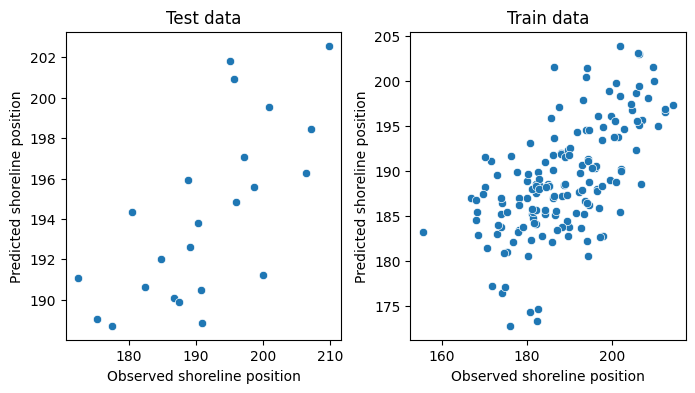

In [26]:
# Scatter plot of the predicted vs. observed shoreline positions
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.scatterplot(data=test_data_out, x='shoreline', y='predicted_shoreline', ax=ax1)
sns.scatterplot(data=train_data_out, x='shoreline', y='predicted_shoreline', ax=ax2)

ax1.set_title('Test data')
ax2.set_title('Train data')

ax1.set_xlabel('Observed shoreline position')
ax1.set_ylabel('Predicted shoreline position')
ax2.set_xlabel('Observed shoreline position')
ax2.set_ylabel('Predicted shoreline position')

plt.subplots_adjust(wspace=0.25)
plt.show()

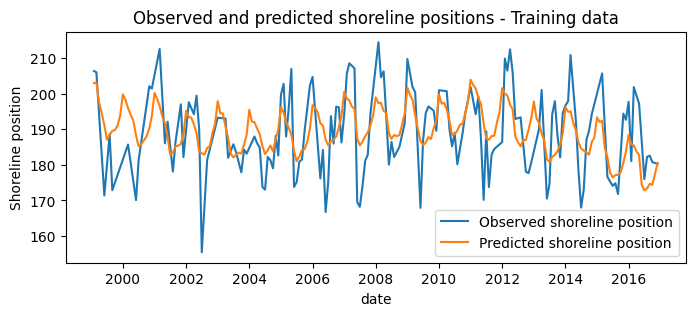

In [27]:
# Plot timeseries of observed and predicted shoreline positions
plt.figure(figsize=(8, 3))
sns.lineplot(data=train_data, x='date', y='shoreline', label='Observed shoreline position')
sns.lineplot(data=train_data_out, x='date', y='predicted_shoreline', label='Predicted shoreline position')
plt.ylabel('Shoreline position')
plt.title('Observed and predicted shoreline positions - Training data')
plt.show()

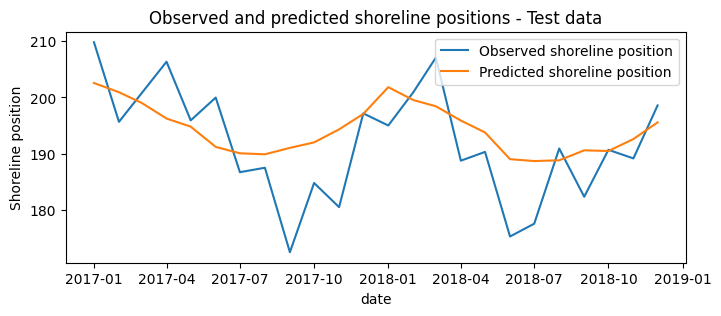

In [28]:
# Plot timeseries of observed and predicted shoreline positions
plt.figure(figsize=(8, 3))
sns.lineplot(data=test_data, x='date', y='shoreline', label='Observed shoreline position')
sns.lineplot(data=test_data_out, x='date', y='predicted_shoreline', label='Predicted shoreline position')
plt.ylabel('Shoreline position')
plt.title('Observed and predicted shoreline positions - Test data')
plt.show()

### Compare model skill
Compare the skill of each model by RMSE, R2 (of dShl), BSS.

In [29]:
# report the RMSE, BSS and R2
print('#'*80)
print('Train - one step')
rmse, r2, bss, r = calc_skill(
    curr_obs=train_data_out['shoreline'],
    prev_obs=train_data_out['shoreline_tminus1'],
    mean_mu=train_data_out['predicted_shoreline'].values
)
print('BSS: {:.2f} | RMSE: {:.2f} | R2: {:.2f} | r: {:.2f}'.format(bss,rmse,r2,r))
print('#'*80)
print('Test - one step')
rmse, r2, bss, r = calc_skill(
    curr_obs=test_data_out['shoreline'],
    prev_obs=test_data_out['shoreline_tminus1'],
    mean_mu=test_data_out['predicted_shoreline'].values
)
print('BSS: {:.2f} | RMSE: {:.2f} | R2: {:.2f} | r: {:.2f}'.format(bss,rmse,r2,r))

################################################################################
Train - one step
BSS: 0.34 | RMSE: 8.90 | R2: 0.12 | r: 0.63
################################################################################
Test - one step
BSS: 0.56 | RMSE: 7.84 | R2: 0.09 | r: 0.71
